In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = ["clean_trace"]


df = pd.read_csv(DF_PREPROC_FILE)
traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

# traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)
# print(traces["syll_labels"].shape)

SAMPLING_RATE = 48_000/8

%load_ext autoreload
%autoreload 2

In [2]:
from djanloo_fourier import FixedResolutionSTFTransformer

fixedtr = FixedResolutionSTFTransformer(n_spectral_points=100, pad_spectra=False)
STFTs = fixedtr.transform(traces["clean_trace"])

  3%|███▍                                                                                                          | 77/2452 [00:00<00:06, 375.21it/s]/home/djanloo/Desktop/DM2/TimeSeries/djanloo_fourier.py:259: RuntimeWarning: divide by zero encountered in log
  transformed_traces.append(np.log(np.abs(STFT.T)))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [00:06<00:00, 371.02it/s]


In [3]:
from keras.layers import Conv1D, Dense, Flatten, AveragePooling1D
from keras.models import Sequential

def build_model(input_shape, n_categories, filters=16, kernel_size=5, n_dense=256):
    
    conv = Conv1D(filters, kernel_size, 
                  input_shape=input_shape,
                 activation="relu")
    pool = AveragePooling1D()
    conv2 = Conv1D(filters, kernel_size, 
                  input_shape=input_shape,
                 activation="relu")
    
    dense = Dense(n_dense, activation="relu")
    flattener= Flatten()
    out_layer = Dense(n_categories, activation="softmax")


    model = Sequential()
    model.add(conv)
    model.add(pool)
    model.add(conv2)
    model.add(dense)
    model.add(flattener)
    model.add(out_layer)

    model.compile(optimizer="adam", 
                  loss="sparse_categorical_crossentropy", 
                  metrics=['accuracy'])
    return model

2023-06-29 14:07:23.871434: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 14:07:24.244447: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 14:07:24.246545: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 14:07:26.168431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

enc = LabelEncoder()
subset = np.ones(len(df)).astype(bool)#(df.vocal_channel == "song")
labels = np.array([f"{s}{e}{vc}" for s,e,vc in zip(df.sex, df.emotion, df.vocal_channel)])

y = enc.fit_transform(labels[subset])
X = pad_sequences(STFTs)[subset]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

print(np.unique(y),"tot", len(np.unique(y)), "samples are", len(y))
print(np.unique(ytrain),"tot", len(np.unique(ytrain)), "samples are", len(ytrain))
print(np.unique(ytest),"tot", len(np.unique(ytest)), "samples are", len(ytest))



test_model = build_model(Xtrain.shape[1:], len(np.unique(y)))
test_model.summary()
hist = test_model.fit(Xtrain, ytrain, epochs=20, validation_split=0.2)

In [6]:
from sklearn.metrics import accuracy_score

ypred = np.argmax(test_model.predict(Xtest), axis=1)

print(accuracy_score(ytest, ypred))

16/16 [==============================] - 1s 17ms/step
0.40529531568228105


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


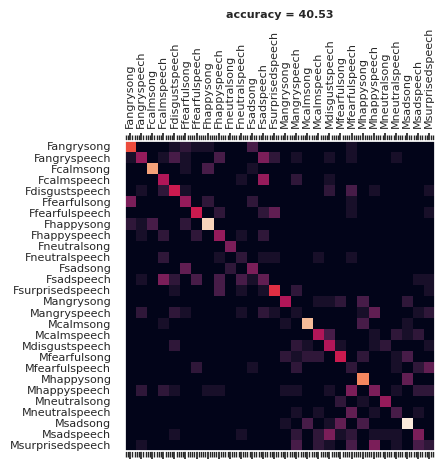

In [7]:
from sklearn.metrics import confusion_matrix

plt.matshow(confusion_matrix(ytest, ypred))
plt.xticks(np.unique(ytest), labels = enc.inverse_transform(np.unique(ytest)), rotation=90);
plt.yticks(np.unique(ytest), labels = enc.inverse_transform(np.unique(ytest)), rotation=0);

plt.title(f"accuracy = {accuracy_score(ytest, ypred)*100:.2f}")
plt.grid(ls="")